### Study the overlap between the coherent tune and the incoherent spectrum by applying FFT on the tbt data of the bunch centroid motion. 

**Schottky method:**

- Track very few particles ~1e4, comparing to the 5e5 particles usually used for the simulations with impedance. There are not enough particles to compute the centroid with accuracy. This noise will result to the incoherent spectrum. That’s why a few particles are needed. Many turns are necessary (here 2**17)

- Note: Due to the small number of macroparticles, in the presence of the impedance most likely you will have some emittance growth. But it is negelted for now. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import os
import sys
sys.path.append('../../utils')
from cmpt_TuneSpreads import *
from coordinatesConversions import *

In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 25,
          'axes.titlesize': 21,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize': 7,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)
plt.close('all')

In [3]:
def find_tune(a): # find and return the frequency with the maximum amplitude
    max_fft = max(a)
    my_index = [i for i, j in enumerate(a) if j == max_fft]
    return my_index
    

### Study parameters

In [7]:
gamma = 287.8
beta = np.sqrt(1 - 1/gamma**2)
circumference = 6911.5623
frev = 299792458/circumference
n_turns = 1e6#2**17
intensity = 3.5e10

ayy, axy = 0.0, 0.0
Qpy=1
wakes = 'ON'

### Load tbt data from tracking

In [52]:
path2data ='/afs/cern.ch/work/n/natriant/private/pyheadtail_example_crabcavity/'
study_name=f'sps_forSchottky_tbt_270GeV_NoNoise_WakesON_ayy-6000_QpxQpy0_6D_Nb5e4_intensity3e10_ayy-16000.0_fixedKicksSet0_run0'

In [53]:
meanX, meanY, emitY, emitX = np.loadtxt(path2data+f'{study_name}/file.txt', delimiter = ",", unpack = True)
#meanX, meanY = np.loadtxt(path2data+f'{study_name}/file.txt', delimiter = ",", unpack = True)

### Perform FFT on the bunch centroid

In [54]:
fft = np.fft.fft(meanY)
n = meanY.size
freq = np.fft.fftfreq(n)

### A) Plot FFT linear scale

tune freq [0.178965]


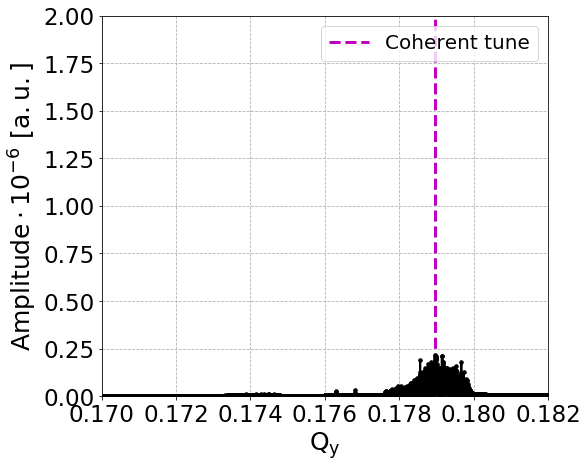

In [55]:
fig, ax = plt.subplots()

ax.plot(freq[:n//2], 1e6*np.abs(fft[:n//2]*1/n), '.-', c='k')

# cmpt tune, as the frequency that corresponds to the max amplitude of the fft
a = np.abs(fft[:n//2])
tune_freq=find_tune(a) 
print(f'tune freq {freq[:n//2][tune_freq]}')


ax.vlines(freq[:n//2][tune_freq], 0, 50, lw=3, ls='--', color='m', label='Coherent tune')

# styling
#ax.set_xlim(0.1785,0.182)
ax.set_xlim(0.17,0.182)
ax.set_ylim(0, 10)
ax.set_ylim(0, 2)

ax.set_xlabel(r'$\mathrm{Q_y}$')
ax.set_ylabel(r'$\mathrm{Amplitude \cdot 10^{-6} \ [a.u.]}$')
ax.grid(linestyle='dashed')

ax.legend(loc=1)

savefig=False
if savefig:
    plt.savefig(f'./output/fft_{study_name}_linear.png', bbox_inches='tight')

### B) Plot FFT log scale

tune freq [0.178965]


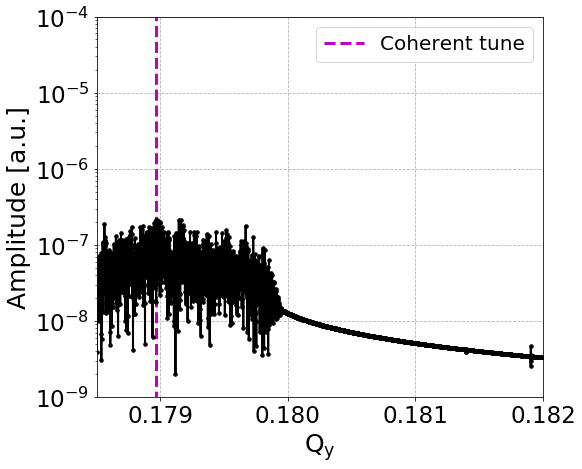

In [56]:
fig, ax = plt.subplots()

ax.plot(freq[:n//2], np.abs(fft[:n//2]*1/n), '.-', c='k')

# cmpt tune, as the frequency that corresponds to the max amplitude of the fft
a = np.abs(fft[:n//2])
tune_freq=find_tune(a) 
print(f'tune freq {freq[:n//2][tune_freq]}')


ax.vlines(freq[:n//2][tune_freq], 0, 1e-4, lw=3, ls='--', color='m', label='Coherent tune') # plot tune

# styling
ax.set_xlabel(r'$\mathrm{Q_y}$')
ax.set_ylabel('Amplitude [a.u.]')
ax.grid(linestyle='dashed')


ax.set_xlim(0.1785,0.182)
ax.set_ylim(1e-9, 1e-4)

ax.legend(loc=1)
ax.set_yscale('log')

savefig=False
if savefig:
    plt.savefig(f'./output/fft_{study_name}_log_noZoom.png', bbox_inches='tight')

### Compute PSD of the bunch centroid

In [51]:
time = np.arange(int(n_turns))/frev # convert from turns to time
Dt = time[1]-time[0] # sampling (s)
print(Dt)

# freq = np.linspace(0, N/time[-1], N)  # [0, 2frev]
freq_psd = np.fft.fftfreq(int(n_turns), Dt) # [-frev/2, frev/2]
Df = freq_psd[1]-freq_psd[0]

print('sampling ratio Df={}'.format(Df))
   
#### To obtain a more precise value of PSD, we use the average of 10000 FFTs
dft_1 = np.abs(fft)**2  
PSD_1 = dft_1/(Df*(n_turns/2)**2) # power spectral density

2.3054490250051584e-05
sampling ratio Df=0.3309287886438057


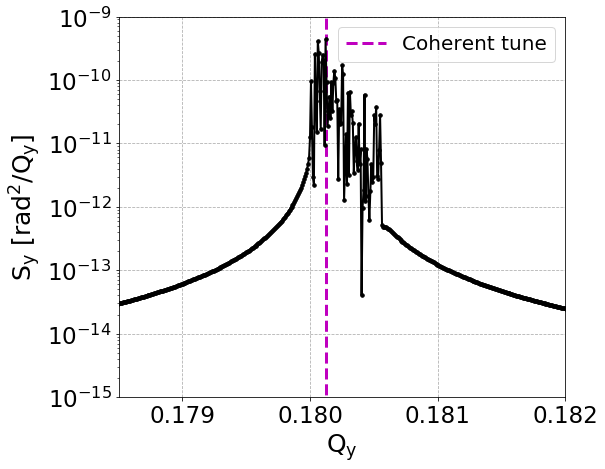

In [52]:
fig, ax = plt.subplots()
ax.plot(np.fft.fftshift(freq_psd)/frev, np.fft.fftshift(PSD_1),'.-', c='k')

ax.vlines(freq_psd[tune_freq]/frev, 0, 1e-7, lw=3, ls='--', color='m', label='Coherent tune') # plot tune


ax.set_xlim(0.1785,0.182)
ax.set_ylim(1e-15, 1e-9)

# styling
ax.grid(linestyle='--')

ax.set_yscale('log')

ax.set_xlabel(r'$\mathrm{Q_y}$')
ax.set_ylabel(r'$\mathrm{S_y \ [rad^2/Q_y]}$') # not entirely sure, discuss it with Hannes.
ax.grid(linestyle='dashed')

ax.legend(loc=1)


savefig=True
if savefig:
    plt.savefig(f'./output/psd_{study_name}_log.png', bbox_inches='tight')

### Compute expected tune spread from amplitude detuning

In [53]:
# Load the initial bunch to compute the initial Jx,Jy
bunch = pickle.load(open(f'{path2data}{study_name}/bunch2', 'rb'))

In [54]:
# Optics at the start of the lattice
beta_y = 73.81671646
beta_x = 30.31164764
alpha_y = 0
alpha_x = 0

# Coordinates
x, px = bunch.x, bunch.xp
y, py =  bunch.y, bunch.yp

# Normalised coordinates 
x_n, px_n = cmpt_normalised_coordinates(x, px, beta_x, alpha_x)
y_n, py_n = cmpt_normalised_coordinates(y, py, beta_y, alpha_y)


# Compute actions
Jx_init = cmpt_actions(x_n, px_n)
Jy_init = cmpt_actions(y_n, py_n)


rms_Jx_init = np.std(Jx_init)
rms_Jy_init = np.std(Jy_init)

print(f'rms(Jx)={rms_Jx_init} m')
print(f'rms(Jy)={rms_Jy_init} m')

rms(Jx)=6.927871945745291e-09 m
rms(Jy)=6.937715741297194e-09 m


In [55]:
expected_DQ = amplitude_detuning_y(Jx_init, Jy_init, ayy, axy)

In [56]:
rms_expected_DQ = rms_amplitude_detuning_y(Jy_init, Jx_init, ayy, axy)
print(f'rms expected DQy {rms_expected_DQ}')

rms expected DQy 8.313446334894349e-05


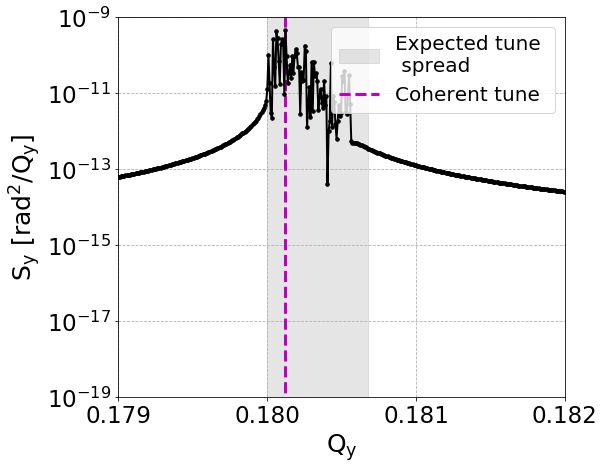

In [57]:
fig, ax = plt.subplots()
ax.plot(np.fft.fftshift(freq_psd)/frev, np.fft.fftshift(PSD_1),'.-', c='k')

ax.vlines(freq_psd[tune_freq]/frev, 0, 1e-7, lw=3, ls='--', color='m', label='Coherent tune') # plot tune

# add span FROM estimated coherent tune UP to maximum tune spread
#ax.axvspan(freq_psd[tune_freq]/frev , freq_psd[tune_freq]/frev+np.max(expected_DQ), alpha=0.2, color='grey', label='Expected tune \n spread')

ax.axvspan(0.18 , freq_psd[tune_freq]/frev+np.max(expected_DQ), alpha=0.2, color='grey', label='Expected tune \n spread')


#ax.set_xlim(0.1785,0.182)
ax.set_xlim(0.179,0.182)
#ax.set_ylim(1e-15, 1e-9)
ax.set_ylim(1e-19, 1e-9)

# styling
ax.grid(linestyle='--')

ax.set_yscale('log')

ax.set_xlabel(r'$\mathrm{Q_y}$')
ax.set_ylabel(r'$\mathrm{S_y \ [rad^2/Q_y]}$') # not entirely sure, discuss it with Hannes.
ax.grid(linestyle='dashed')

ax.legend(loc=1)


savefig=True
if savefig:
    plt.savefig(f'./output/psdVSexpectedDQy_{study_name}_log.png', bbox_inches='tight')

In [120]:
freq_psd[tune_freq]/frev-0.18

array([6.89697266e-05])

### Estimate expected coherent tune shift from impedance ONLY
- From Sacherer's formula. Eq (8) and (9) Handbook of accelerator Physics A.Chao, paragraph 2.5.7

In [18]:
from scipy import constants as cst

In [19]:
def hmm_gauss(freq,tau,m=0): # psd of gaussian bunch oscillating in modes, m
    return (2.0*np.pi*freq*tau/4)**(2*m) * np.exp(-(2.0*np.pi*freq*tau/4.)**2)

In [20]:
N = 3.5E10
Qy = 26.18
Qs = 0.0051
gamma_t = 22.8
energy = 270.0
gamma = np.sqrt(1+(energy/0.938)**2)
circum = 2*np.pi*1.1E3
frev = cst.c/circum
eta = 1/gamma_t**2 - 1/gamma**2
tau = 1.85E-9 # bunch length in sec, 4 sigmat
sigmaz = tau*cst.c/4
chroma = 0.0

In [21]:
#### Impedance model from https://gitlab.cern.ch/IRIS/SPS_IW_model/-/tree/master/SPS_IW_model_python ###########################################
path2impedance='/home/natalia/PhD_projects/headtail_instabilities_and_impedance/from_Xavier/'
impedanceData = np.genfromtxt(path2impedance+'SPS_Complete_imp_model_2018_Q26.txt', skip_header=1, dtype=complex) # type: array
freqZ = np.real(impedanceData[:, 0])*1E6
#ReZ = np.real(impedanceData[:, 2]) # dipole Y, why this?
ImZ = np.imag(impedanceData[:, 2])

#### Sacherer formula (e.g. 8 and 9 in Sec 2.5.7 in Handbook of Accelerator physics and engineering from A. Chao and M. Tigner) ################
modeNumber = 0
nSideband = int(np.floor((1E10/frev))) # not well understood, why 1e10??
sidebands = np.arange(-nSideband, nSideband+0.5)

In [22]:
chromaShift = chroma*frev/eta  # chromatic frequency shift
freqs = frev * (0.18 + sidebands + modeNumber * Qs) # create a floor of frequencies for the "integration"

hs = hmm_gauss(freqs-chromaShift, tau, m=modeNumber) # mode spectrum

#zeffs = np.interp(np.abs(freqs),freqZ,ReZ)*np.sign(freqs)*hs
zeffs = np.interp(np.abs(freqs), freqZ, ImZ) * np.sign(freqs) * hs
zeffs /= np.sum(hs)
zeff = np.sum(zeffs)



dampingRate = zeff * cst.e ** 2 * N / (16.0 * np.pi * cst.m_p * gamma * Qy * frev * sigmaz* 2*np.pi)
#dampingRate = zeff * cst.e ** 2 * N / (16.0 * np.pi * cst.m_p * gamma * Qy  * sigmaz)


In [23]:
dampingRate

2.7088743149631787e-08

### Studies of the x-plane

In [24]:
fft = np.fft.fft(meanX)
n = meanY.size
freq = np.fft.fftfreq(n)

tune freq [0.12998199]


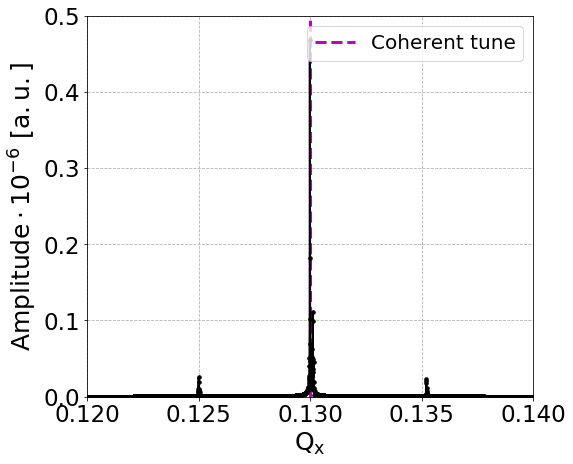

In [49]:
fig, ax = plt.subplots()

ax.plot(freq[:n//2], 1e6*np.abs(fft[:n//2]*1/n), '.-', c='k')

# cmpt tune, as the frequency that corresponds to the max amplitude of the fft
a = np.abs(fft[:n//2])
tune_freq=find_tune(a) 
print(f'tune freq {freq[:n//2][tune_freq]}')


ax.vlines(freq[:n//2][tune_freq], 0, 0.5, lw=3, ls='--', color='m', label='Coherent tune')

# styling
ax.set_xlim(0.12,0.14)
ax.set_ylim(0, 0.5)

ax.set_xlabel(r'$\mathrm{Q_x}$')
ax.set_ylabel(r'$\mathrm{Amplitude \cdot 10^{-6} \ [a.u.]}$')
ax.grid(linestyle='dashed')

ax.legend(loc=1)

savefig=False
if savefig:
    plt.savefig(f'./output/fft_Qx_{study_name}_linear.png', bbox_inches='tight')

In [44]:
time = np.arange(int(n_turns))/frev # convert from turns to time
Dt = time[1]-time[0] # sampling (s)
print(Dt)

# freq = np.linspace(0, N/time[-1], N)  # [0, 2frev]
freq_psd = np.fft.fftfreq(int(n_turns), Dt) # [-frev/2, frev/2]
Df = freq_psd[1]-freq_psd[0]

print('sampling ratio Df={}'.format(Df))
   
#### To obtain a more precise value of PSD, we use the average of 10000 FFTs
dft_1 = np.abs(fft)**2  
PSD_1 = dft_1/(Df*(n_turns/2)**2) # power spectral density

2.30542952414685e-05
sampling ratio Df=0.33093158785989535


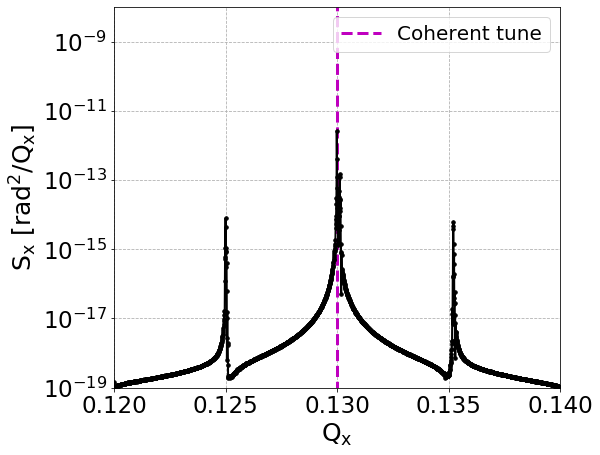

In [54]:
fig, ax = plt.subplots()
ax.plot(np.fft.fftshift(freq_psd)/frev, np.fft.fftshift(PSD_1),'.-', c='k')

ax.vlines(freq_psd[tune_freq]/frev, 0, 1e-8, lw=3, ls='--', color='m', label='Coherent tune') # plot tune

ax.set_xlim(0.12,0.14)
ax.set_ylim(1e-19, 1e-8)


# styling
ax.grid(linestyle='--')

ax.set_yscale('log')

ax.set_xlabel(r'$\mathrm{Q_x}$')
ax.set_ylabel(r'$\mathrm{S_x \ [rad^2/Q_x]}$') # not entirely sure, discuss it with Hannes.
ax.grid(linestyle='dashed')

ax.legend(loc=1)


savefig=False
if savefig:
    plt.savefig(f'./output/psd_Qx_{study_name}_log.png', bbox_inches='tight')

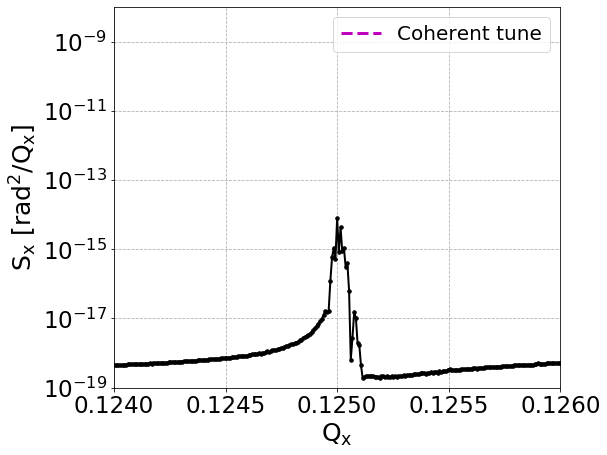

In [59]:
fig, ax = plt.subplots()
ax.plot(np.fft.fftshift(freq_psd)/frev, np.fft.fftshift(PSD_1),'.-', c='k')

ax.vlines(freq_psd[tune_freq]/frev, 0, 1e-8, lw=3, ls='--', color='m', label='Coherent tune') # plot tune

ax.set_xlim(0.124,0.126)
ax.set_ylim(1e-19, 1e-8)


# styling
ax.grid(linestyle='--')

ax.set_yscale('log')

ax.set_xlabel(r'$\mathrm{Q_x}$')
ax.set_ylabel(r'$\mathrm{S_x \ [rad^2/Q_x]}$') # not entirely sure, discuss it with Hannes.
ax.grid(linestyle='dashed')

ax.legend(loc=1)


savefig=False
if savefig:
    plt.savefig(f'./output/psd_Qx_{study_name}_log_ZoomPositiveSidebande.png', bbox_inches='tight')

### Plot the emittance evolution, x-plane

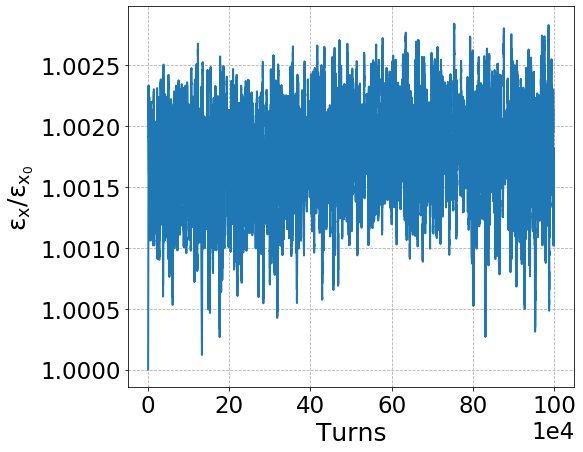

In [28]:
fig, ax = plt.subplots()

ax.plot(np.arange(n_turns), emitX/emitX[0])#, label=f'Intensity={intensity/1e10:.2f}e10')
    
# styling
ax.grid(linestyle='--')

    
ax.ticklabel_format(axis="x", style="sci", scilimits=(4,4))

ax.set_xlabel('Turns')
ax.set_ylabel(r'$\mathrm{\epsilon_x/ \epsilon_{x_0}}$') # not entirely sure, discuss it with Hannes.
ax.grid(linestyle='dashed')


savefig = False
if savefig:
    plt.savefig(f'output/emitX_{study_name}_intensity{intensity/1e10:.2f}e10.png', bbox_inches='tight')

### Plot the emittance evolution, y-plane

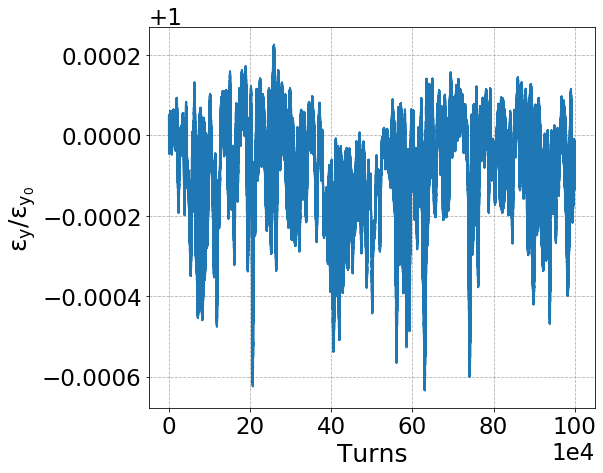

In [26]:
fig, ax = plt.subplots()

ax.plot(np.arange(n_turns), emitY/emitY[0])#, label=f'Intensity={intensity/1e10:.2f}e10')
    
# styling
ax.grid(linestyle='--')

    
ax.ticklabel_format(axis="x", style="sci", scilimits=(4,4))

ax.set_xlabel('Turns')
ax.set_ylabel(r'$\mathrm{\epsilon_y/ \epsilon_{y_0}}$') # not entirely sure, discuss it with Hannes.
ax.grid(linestyle='dashed')


savefig = False
if savefig:
    plt.savefig(f'output/emitY_{study_name}_intensity{intensity/1e10:.2f}e10.png', bbox_inches='tight')